<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 100
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_train shape : {x_test.shape}, y_train shape : {y_test.shape}")

x_train shape : (50000, 32, 32, 3), y_train shape : (50000, 1)
x_train shape : (10000, 32, 32, 3), y_train shape : (10000, 1)


In [ ]:
batch_size = 256
image_size = 224
patch_size = 32
num_patches = (image_size//patch_size)**2

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim*2,
    projection_dim
]

transformer_layer = 12
mlp_head_units = [2048, 1024]

In [ ]:
data_augumentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name = 'data_augumentation'
)

data_augumentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):

  for units in hidden_units:
    x=layers.Dense(units, activation=tf.nn.gelu)(x)
    x=layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

image size: 224 X 224
pathc size : 32 X 32
patches per image : 49
elemetns per patch : 3072
shape of patch: (1, 49, 3072)


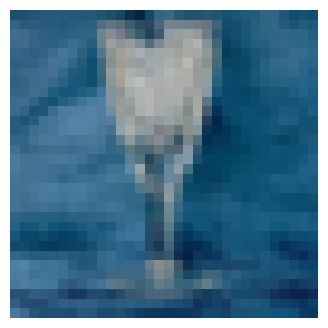

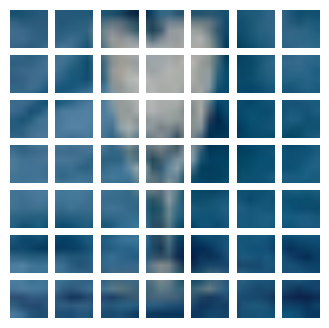

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'image size: {image_size} X {image_size}')
print(f'pathc size : {patch_size} X {patch_size}')
print(f'patches per image : {patches.shape[1]}')
print(f'elemetns per patch : {patches.shape[-1]}')
print(f'shape of patch: {patches.shape}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype('uint8'))
  plt.axis('off')

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    position = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(position)
    return encoded

In [ ]:
def vit():
  inputs = layers.Input(shape=input_shape)
  augmented = data_augumentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  for _ in range(transformer_layer):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim = projection_dim,
        dropout=0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

    encoded_patches = layers.Add()([x3, x2])

  represantation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  represantation = layers.Flatten()(represantation)
  represantation = layers.Dropout(0.5)(represantation)

  features = mlp(represantation, hidden_units=mlp_head_units, dropout_rate = 0.5)
  logits = layers.Dense(num_classes)(features)
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
model = vit()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augumentation (Sequen  (None, 224, 224, 3)          7         ['input_7[0][0]']             
 tial)                                                                                            
                                                                                                  
 patches_13 (Patches)        (None, None, 3072)           0         ['data_augumentation[0][0]']  
                                                                                                  
 patch_encoder_5 (PatchEnco  (None, 49, 64)               199808    ['patches_13[0][0]']    

In [ ]:
num_epochs=20
weight_decay=0.001
learing_rate = 0.001

optimizer = tfa.optimizers.AdamW(
    lr = learing_rate, weight_decay = weight_decay
)

model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
    keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top-5-accuracy')
]

)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
176/176 [==============================] - 37s 151ms/step - loss: 4.3744 - accuracy: 0.0567 - top-5-accuracy: 0.1878 - val_loss: 3.8132 - val_accuracy: 0.1180 - val_top-5-accuracy: 0.3354
Epoch 2/20
176/176 [==============================] - 25s 145ms/step - loss: 3.8510 - accuracy: 0.1114 - top-5-accuracy: 0.3207 - val_loss: 3.5068 - val_accuracy: 0.1678 - val_top-5-accuracy: 0.4144
Epoch 3/20
176/176 [==============================] - 26s 148ms/step - loss: 3.6070 - accuracy: 0.1461 - top-5-accuracy: 0.3947 - val_loss: 3.3016 - val_accuracy: 0.2010 - val_top-5-accuracy: 0.4790
Epoch 4/20
176/176 [==============================] - 27s 152ms/step - loss: 3.4267 - accuracy: 0.1768 - top-5-accuracy: 0.4448 - val_loss: 3.1944 - val_accuracy: 0.2244 - val_top-5-accuracy: 0.5012
Epoch 5/20
176/176 [==============================] - 27s 154ms/step - loss: 3.2936 - accuracy: 0.2006 - top-5-accuracy: 0.4796 - val_loss: 3.0979 - val_accuracy: 0.2474 - val_top-5-accuracy: 0.5308
Epoch

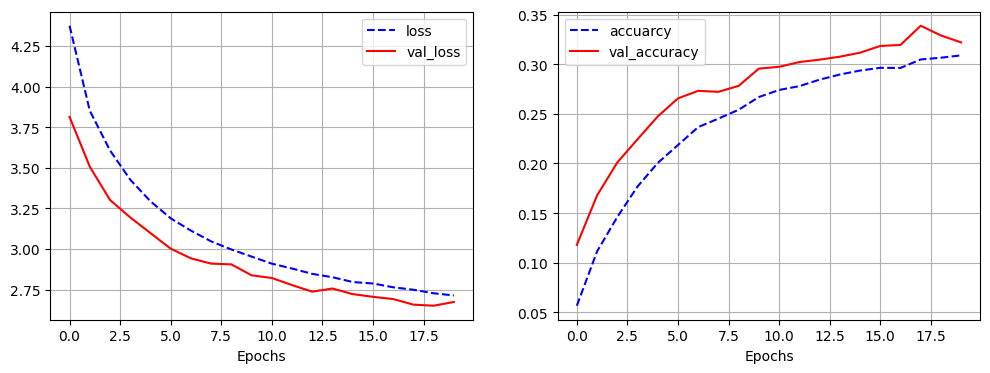

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label = 'accuarcy')
plt.plot(history.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()